<a href="https://colab.research.google.com/github/cbenincasa/MBA-case-classificacao/blob/main/ESTUDO_CASO_CLASSIFICACAO_CARLOS_BENINCASA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Case: Credit Score*
---



### **Bibliotecas**

In [62]:
# Instalação de bibliotecas não disponíveis na instalação padrão do Python no Google Colab
# ! pip install shap

In [63]:
import pandas as pd                                                                # Manipulação de dados
import numpy as np                                                                 # Realização de cálculos específicos
import matplotlib.pyplot as plt                                                    # Visualização de dados
import seaborn as sns                                                              # Visualização de dados
import time                                                                        # Cálculo de tempo de execução
import math                                                                        # Funções matemáticas
from scipy.stats import randint, uniform, loguniform                               # Geração de valores aleatórios
from sklearn.compose import ColumnTransformer                                      # Transformação de colunas
from sklearn.preprocessing import StandardScaler, OneHotEncoder                    # Transformação de colunas
from sklearn.base import clone                                                     # Criação de cópias de modelos
from sklearn.model_selection import train_test_split                               # Validação simples
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV            # Validação cruzada e estratificação de folds
from sklearn.utils.class_weight import compute_sample_weight                       # Cálculo de pesos para observações
from sklearn.linear_model import SGDClassifier                                     # Regressão logística com regularização
from sklearn.tree import DecisionTreeClassifier, plot_tree                                    # Árvore de decisão
from sklearn.ensemble import RandomForestClassifier                                # Floresta aleatória
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier        # Impulsionamento tradicional
from sklearn.ensemble import HistGradientBoostingClassifier                        # Impulsionamento com histogramas
from xgboost import XGBClassifier                                                  # Impulsionamento via XGBoost
from lightgbm import LGBMClassifier                                                # Impulsionamento via LightGBM
from sklearn.calibration import CalibratedClassifierCV                             # Calibração de probabilidades
from sklearn.calibration import calibration_curve                                  # Gráfico de curva de calibração
from sklearn.metrics import brier_score_loss                                       # Score de Brier
from sklearn.metrics import accuracy_score, confusion_matrix                       # Análise de desempenho: matriz de classificação
from sklearn.metrics import get_scorer, roc_auc_score, roc_curve                   # Análise de desempenho: KS e AUC
from sklearn.inspection import permutation_importance                              # Importância de variáveis por permutação
import shap                                                                        # Interpretabilidade de variáveis nos modelos
import statsmodels.api as sm                                                    # Ajuste de modelos de regressão
from statsmodels.stats.outliers_influence import variance_inflation_factor      # Cálculo do VIF
from sklearn.preprocessing import label_binarize                                   # Binarização da resposta (Score de Brier one-vs-rest)

### **Leitura da base de dados**

In [64]:
dados = pd.read_table("Credit_Score.txt",
                      sep="\t",
                      decimal=".",
                      header=0)

### **Visualização da base de dados**

In [65]:
dados.head()

,ID,SAFRA,IDADE,RENDA_MEDIA_MENSAL,TOTAL_INVESTIMENTOS,QTDE_CONSULTAS_CREDITO_12M,QTDE_CARTOES,QTDE_EMPRESTIMOS_12M,QTDE_CHEQUE_ESPECIAL_12M,QTDE_PGTOS_EM_ATRASO_12M,TOTAL_DIAS_ATRASO_12M,FLAG_PGTO_PARCIAL_12M,VALOR_PGTOS_12M,PERC_MEDIO_LIMITE_TOMADO_12M,RESPOSTA_MAU_BOM
0,0x10002,Safra 2,18,22900,75100,8,9,3,3,6,38,Sim,4246,0.050,1
1,0x1000e,Safra 2,18,6000,0,1,3,1,1,4,24,Sim,15013,0.700,1
2,0x1001a,Safra 1,18,6900,4800,2,2,0,2,1,8,Sim,3361,0.800,1
3,0x1001b,Safra 3,18,23700,2000,1,3,1,2,3,28,Sim,5369,0.320,0
4,0x1001c,Safra 2,18,7000,4400,0,2,0,1,1,5,Nao,21381,0.260,1


### **Dimensões da base de dados**

In [66]:
dados.shape

(18258, 15)

### **Tipos das colunas da base de dados**

In [67]:
dados.dtypes

,0
ID,object
SAFRA,object
IDADE,int64
RENDA_MEDIA_MENSAL,int64
TOTAL_INVESTIMENTOS,int64
QTDE_CONSULTAS_CREDITO_12M,int64
QTDE_CARTOES,int64
QTDE_EMPRESTIMOS_12M,int64
QTDE_CHEQUE_ESPECIAL_12M,int64
QTDE_PGTOS_EM_ATRASO_12M,int64


### **Questão 1**

**Etapa 1: Especificação de variáveis e análise bivariada**

*Lista de nomes das variáveis explicativas, separando em quantitativas e qualitativas*

In [68]:
# Variáveis explicativas quantitativas (deixar vazio [] caso não haja nenhuma)
lista_X_quanti = [
    'IDADE',
    'RENDA_MEDIA_MENSAL',
    'TOTAL_INVESTIMENTOS',
    'QTDE_CONSULTAS_CREDITO_12M',
    'QTDE_CARTOES',
    'QTDE_EMPRESTIMOS_12M',
    'QTDE_CHEQUE_ESPECIAL_12M',
    'QTDE_PGTOS_EM_ATRASO_12M',
    'TOTAL_DIAS_ATRASO_12M',
    'VALOR_PGTOS_12M',
    'PERC_MEDIO_LIMITE_TOMADO_12M'
]

# Variáveis explicativas qualitativas (deixar vazio [] caso não haja nenhuma)
lista_X_quali = [
    'FLAG_PGTO_PARCIAL_12M'
]

*Objetos para variável resposta (y) e explicativas (X)*

In [69]:
y = dados['RESPOSTA_MAU_BOM']
X = dados[lista_X_quali + lista_X_quanti]

**Análise univariada: variável resposta**

In [70]:
y.value_counts()

,count
RESPOSTA_MAU_BOM,
1,15293
0,2965


In [71]:
y.value_counts(normalize=True)

,proportion
RESPOSTA_MAU_BOM,
1,0.838
0,0.162


Percebe-se um desbalanceamento da distribuição das categorias na variável resposta.

### **Questão 2:** Análise bivariada: gráficos de boxplot para variáveis explicativas quantitativas versus variável resposta

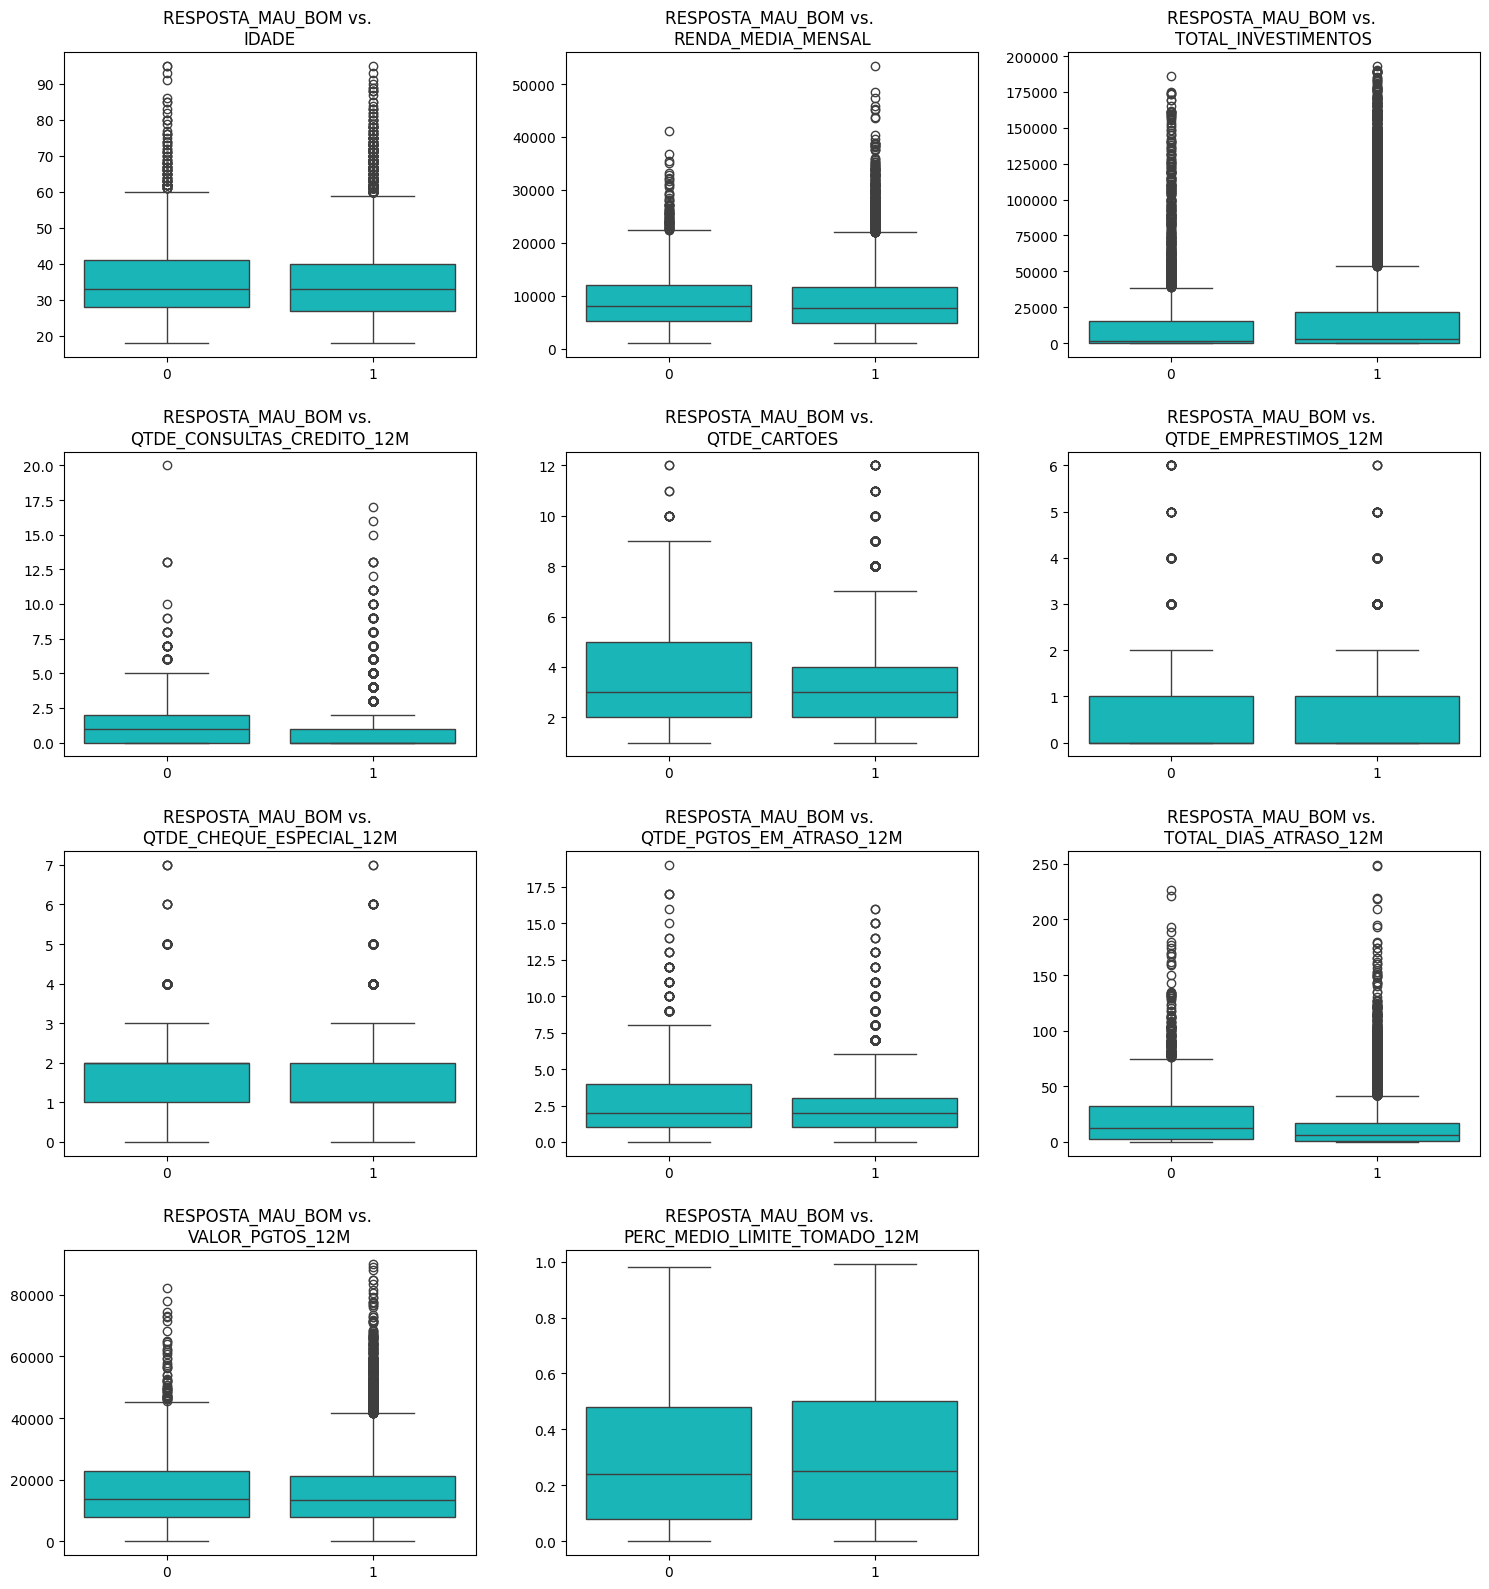

In [72]:
if lista_X_quanti:
    n = len(lista_X_quanti)
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, var in enumerate(lista_X_quanti):
        sns.boxplot(y=dados[var],
                    x=y,
                    ax=axes[i],
                    color='darkturquoise')
        axes[i].set_title(f'{y.name} vs. \n{var}')
        axes[i].tick_params(axis='x', rotation=0)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout(h_pad=2, w_pad=2)
    plt.show()

*Codificação one-hot para variáveis qualitativas*

In [73]:
# Criando um objeto da classe OneHotEncoder (dropando a primeira categoria de cada variável)
codificador_one_hot = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Criando as variáveis dummies e salvando em um objeto à parte
aux_dummies = codificador_one_hot.fit_transform(dados[lista_X_quali])

# Criando nomes para as variáveis dummies
col_names = codificador_one_hot.get_feature_names_out(lista_X_quali)

# Transformando o novo objeto criado em um DataFrame
aux_dummies = pd.DataFrame(aux_dummies, columns=col_names, index=dados.index)

In [74]:
X = pd.concat([dados[lista_X_quanti], aux_dummies], axis=1)
y = dados['RESPOSTA_MAU_BOM']

*Análise bivariada: gráficos de barras empilhadas 100% para variáveis explicativas qualitativas versus variável resposta*

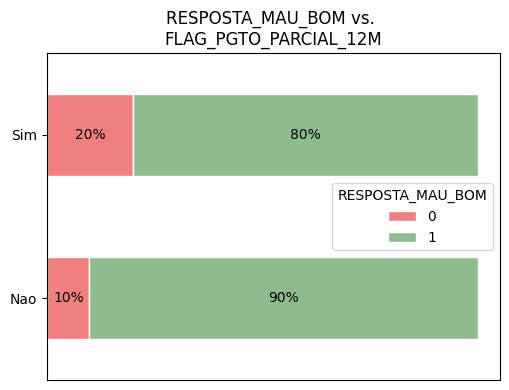

In [75]:
if lista_X_quali:
    n = len(lista_X_quali)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, var in enumerate(lista_X_quali):
        ct = pd.crosstab(dados[var], y, normalize='index')
        ct.plot(kind='barh',
                stacked=True,
                ax=axes[i],
                color=['lightcoral', 'darkseagreen'],
                edgecolor='white')
        axes[i].set_title(f'{y.name} vs. \n{var}')
        axes[i].tick_params(axis='x', rotation=0)
        axes[i].set_xticks([])
        axes[i].set_ylabel("")
        for container in axes[i].containers:
            axes[i].bar_label(container,
                              labels=[f"{w.get_width()*100:.0f}%" for w in container],
                              label_type='center')
        if i != 0:
            axes[i].legend_.remove()  # Manter legenda apenas no primeiro gráfico

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout(h_pad=2, w_pad=2)
    plt.show()

### **Questão 3**: Modelo de regressão logística

*Ajuste do modelo 1*

In [76]:
modelo_1 = sm.Logit(y, sm.add_constant(X)).fit()
print(modelo_1.summary())

Optimization terminated successfully.
         Current function value: 0.421003
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18245
Method:                           MLE   Df Model:                           12
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                 0.05098
Time:                        18:10:36   Log-Likelihood:                -7686.7
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                4.705e-169
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.4960      0.101     24.827      0.000

In [77]:
#Considerando o nível de confiança de 95% (p<=0.05), vamos remover a variável com maior p-valor QTDE_CONSULTAS_CREDITO_12M
X = X.drop(['QTDE_CONSULTAS_CREDITO_12M'], axis=1)
modelo_2 = sm.Logit(y, sm.add_constant(X)).fit()
print(modelo_2.summary())

Optimization terminated successfully.
         Current function value: 0.421003
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18246
Method:                           MLE   Df Model:                           11
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                 0.05098
Time:                        18:10:36   Log-Likelihood:                -7686.7
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                5.305e-170
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.4956      0.100     24.995      0.000

In [78]:
#Considerando o nível de confiança de 95% (p<=0.05), vamos remover a variável com maior p-valor PERC_MEDIO_LIMITE_TOMADO_12M
X = X.drop(['PERC_MEDIO_LIMITE_TOMADO_12M'], axis=1)
modelo_3 = sm.Logit(y, sm.add_constant(X)).fit()
print(modelo_3.summary())

Optimization terminated successfully.
         Current function value: 0.421004
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18247
Method:                           MLE   Df Model:                           10
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                 0.05098
Time:                        18:10:36   Log-Likelihood:                -7686.7
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                5.776e-171
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.5011      0.095     26.352      0.000       2.

In [79]:
#Considerando o nível de confiança de 95% (p<=0.05), vamos remover a variável com maior p-valor QTDE_CARTOES
X = X.drop(['QTDE_CARTOES'], axis=1)
modelo_4 = sm.Logit(y, sm.add_constant(X)).fit()
print(modelo_4.summary())

Optimization terminated successfully.
         Current function value: 0.421008
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18248
Method:                           MLE   Df Model:                            9
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                 0.05097
Time:                        18:10:36   Log-Likelihood:                -7686.8
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                6.278e-172
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.5092      0.092     27.159      0.000       2.

In [80]:
#Considerando o nível de confiança de 95% (p<=0.05), vamos remover a variável com maior p-valor RENDA_MEDIA_MENSAL
X = X.drop(['RENDA_MEDIA_MENSAL'], axis=1)
modelo_5 = sm.Logit(y, sm.add_constant(X)).fit()
print(modelo_5.summary())

Optimization terminated successfully.
         Current function value: 0.421015
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18249
Method:                           MLE   Df Model:                            8
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                 0.05096
Time:                        18:10:36   Log-Likelihood:                -7686.9
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                6.763e-173
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.5221      0.089     28.437      0.000       2.

In [81]:
#Considerando o nível de confiança de 95% (p<=0.05), vamos remover a variável com maior p-valor TOTAL_DIAS_ATRASO_12M
X = X.drop(['TOTAL_DIAS_ATRASO_12M'], axis=1)
modelo_6 = sm.Logit(y, sm.add_constant(X)).fit()
print(modelo_6.summary())

Optimization terminated successfully.
         Current function value: 0.421026
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18250
Method:                           MLE   Df Model:                            7
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                 0.05093
Time:                        18:10:37   Log-Likelihood:                -7687.1
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                7.410e-174
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.5249      0.089     28.502      0.000       2.

In [82]:
#Considerando o nível de confiança de 95% (p<=0.05), vamos remover a variável com maior p-valor IDADE
X = X.drop(['IDADE'], axis=1)
modelo_7 = sm.Logit(y, sm.add_constant(X)).fit()
print(modelo_7.summary())

Optimization terminated successfully.
         Current function value: 0.421105
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18251
Method:                           MLE   Df Model:                            6
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                 0.05075
Time:                        18:10:37   Log-Likelihood:                -7688.5
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                2.538e-174
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.4070      0.055     43.840      0.000       2.

*Avaliação de colinearidade no modelo*

In [83]:
modelo = modelo_7
vif = pd.DataFrame({
    "Variável": modelo.model.exog_names,
    "VIF": [variance_inflation_factor(modelo.model.exog, i) for i in range(modelo.model.exog.shape[1])]
})

print(vif)

                    Variável   VIF
0                      const 5.899
1        TOTAL_INVESTIMENTOS 1.014
2       QTDE_EMPRESTIMOS_12M 1.284
3   QTDE_CHEQUE_ESPECIAL_12M 1.186
4   QTDE_PGTOS_EM_ATRASO_12M 1.247
5            VALOR_PGTOS_12M 1.274
6  FLAG_PGTO_PARCIAL_12M_Sim 1.441


### **Questão 4**: Avaliação de desempenho do modelo de regressão logística

*Aplicação do modelo na base*

In [84]:
dados['Probabilidade'] = modelo.predict()

*Definição de ponto de corte (padrão: % de 1's na amostra - Bons pagadores)*

In [85]:
ponto_corte = dados['RESPOSTA_MAU_BOM'].mean()
ponto_corte

np.float64(0.8376054332347465)

*Atribuição da resposta predita pelo modelo*

In [86]:
dados['Predito'] = (dados['Probabilidade'] > ponto_corte).astype(int)

Análise de desempenho

*Tabela de classificação*

In [87]:
tabela = pd.crosstab(dados['RESPOSTA_MAU_BOM'], dados['Predito'])
tabela

Predito,0,1
RESPOSTA_MAU_BOM,,
0,1737,1228
1,5329,9964


*Desempenho: acurácia, sensibilidade, especificidade, PPV e NPV*

In [88]:
acuracia       = accuracy_score(dados['RESPOSTA_MAU_BOM'], dados['Predito'])
tn, fp, fn, tp = confusion_matrix(dados['RESPOSTA_MAU_BOM'], dados['Predito']).ravel()
sensibilidade  = tp / (tp + fn)
especificidade = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print(f'Acurácia: {acuracia:.3f}')
print(f'Sensibilidade: {sensibilidade:.3f}')
print(f'Especificidade: {especificidade:.3f}')
print(f'PPV: {ppv:.3f}')
print(f'NPV: {npv:.3f}')

Acurácia: 0.641
Sensibilidade: 0.652
Especificidade: 0.586
PPV: 0.890
NPV: 0.246


In [89]:
# KS
fpr, tpr, _ = roc_curve(dados['RESPOSTA_MAU_BOM'], dados['Probabilidade'])
ks = np.max(tpr - fpr)
print(f'KS: {ks:.3f}')

KS: 0.239


In [90]:
# AUC
auc = roc_auc_score(dados['RESPOSTA_MAU_BOM'], dados['Probabilidade'])
print(f'AUC: {auc:.3f}')

AUC: 0.656


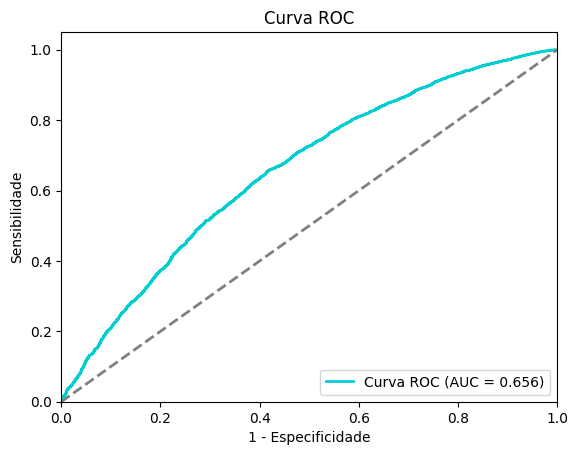

In [91]:
# Exibição da curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkturquoise', lw=2, label='Curva ROC (AUC = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Especificidade')
plt.ylabel('Sensibilidade')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### **Questão 5**: Construção de modelos de árvore de decisão

Recarregando dados para construção dos modelos de árvore

*Lista de nomes das variáveis explicativas, separando em quantitativas e qualitativas*

In [92]:
# Variáveis explicativas quantitativas (deixar vazio [] caso não haja nenhuma)
lista_X_quanti = [
    'IDADE',
    'RENDA_MEDIA_MENSAL',
    'TOTAL_INVESTIMENTOS',
    'QTDE_CONSULTAS_CREDITO_12M',
    'QTDE_CARTOES',
    'QTDE_EMPRESTIMOS_12M',
    'QTDE_CHEQUE_ESPECIAL_12M',
    'QTDE_PGTOS_EM_ATRASO_12M',
    'TOTAL_DIAS_ATRASO_12M',
    'VALOR_PGTOS_12M',
    'PERC_MEDIO_LIMITE_TOMADO_12M'
]

# Variáveis explicativas qualitativas (deixar vazio [] caso não haja nenhuma)
lista_X_quali = [
    'FLAG_PGTO_PARCIAL_12M'
]

*Objetos para variável resposta (y) e explicativas (X)*

In [93]:
y = dados['RESPOSTA_MAU_BOM']
X = dados[lista_X_quali + lista_X_quanti]

**Divisão de treino e teste externo**

*Divisão inicial*

In [94]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=123)

In [95]:
y_treino.value_counts()

,count
RESPOSTA_MAU_BOM,
1,12234
0,2372


**Pré-processamento de variáveis explicativas**

*Definição das funções de pré-processamento: Padronização das variáveis quantitativas + Codificação one-hot para variáveis qualitativas*

In [96]:
preprocessador = ColumnTransformer(transformers=[
    # Não é necessário padronizar variáveis quantitativas em algoritmos baseados em árvores
    # ("quanti", StandardScaler(), lista_X_quanti),
    ("quali", OneHotEncoder(sparse_output=False, drop="first", handle_unknown='ignore'), lista_X_quali)
],
    remainder="passthrough"
)

*Criação do pré-processamento no conjunto de treino* <br>

In [97]:
X_treino_tratada = preprocessador.fit_transform(X_treino)  # O pré-processamento não deve envolver o conjunto de teste externo, que deve ficar reservado apenas para aplicações de resultados já obtidos, e nunca construções
if lista_X_quali:
    nomes_quali = list(preprocessador.named_transformers_['quali'].get_feature_names_out(lista_X_quali))
else:
    nomes_quali = []
nomes_variaveis = nomes_quali + list(lista_X_quanti)

In [98]:
X_treino_tratada = pd.DataFrame(X_treino_tratada, columns=nomes_variaveis)
X_treino_tratada.head()

,FLAG_PGTO_PARCIAL_12M_Sim,IDADE,RENDA_MEDIA_MENSAL,TOTAL_INVESTIMENTOS,QTDE_CONSULTAS_CREDITO_12M,QTDE_CARTOES,QTDE_EMPRESTIMOS_12M,QTDE_CHEQUE_ESPECIAL_12M,QTDE_PGTOS_EM_ATRASO_12M,TOTAL_DIAS_ATRASO_12M,VALOR_PGTOS_12M,PERC_MEDIO_LIMITE_TOMADO_12M
0,0.000,31.000,2800.000,5300.000,1.000,1.000,0.000,1.000,0.000,0.000,3967.000,0.100
1,0.000,37.000,5200.000,77300.000,5.000,2.000,0.000,1.000,1.000,5.000,14361.000,0.800
2,1.000,34.000,11300.000,7200.000,3.000,3.000,2.000,2.000,2.000,36.000,11620.000,0.170
3,1.000,39.000,11200.000,2500.000,0.000,2.000,0.000,2.000,2.000,6.000,21120.000,0.020
4,1.000,28.000,6100.000,100.000,2.000,6.000,2.000,2.000,3.000,66.000,13500.000,0.200


*Aplicação do pré-processamento no conjunto de teste externo*

In [99]:
X_teste_tratada = preprocessador.transform(X_teste)  # Note que o mesmo objeto de pré-processamento deve ser utilizado, agora com 'transform' em vez de 'fit_transform'
X_teste_tratada = pd.DataFrame(X_teste_tratada, columns=nomes_variaveis)
X_teste_tratada.head()

,FLAG_PGTO_PARCIAL_12M_Sim,IDADE,RENDA_MEDIA_MENSAL,TOTAL_INVESTIMENTOS,QTDE_CONSULTAS_CREDITO_12M,QTDE_CARTOES,QTDE_EMPRESTIMOS_12M,QTDE_CHEQUE_ESPECIAL_12M,QTDE_PGTOS_EM_ATRASO_12M,TOTAL_DIAS_ATRASO_12M,VALOR_PGTOS_12M,PERC_MEDIO_LIMITE_TOMADO_12M
0,1.000,24.000,9700.000,132100.000,0.000,2.000,0.000,1.000,3.000,4.000,6044.000,0.390
1,1.000,19.000,2300.000,300.000,0.000,2.000,0.000,3.000,1.000,8.000,19408.000,0.110
2,1.000,23.000,18300.000,10100.000,4.000,5.000,1.000,3.000,1.000,40.000,4653.000,0.010
3,1.000,51.000,18500.000,52800.000,4.000,5.000,1.000,3.000,6.000,52.000,4630.000,0.610
4,1.000,41.000,3000.000,8200.000,0.000,2.000,0.000,0.000,1.000,3.000,9706.000,0.190


**Definição do algoritmo e intervalos de busca de hiperparâmetros**

In [100]:
algoritmos = {

    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(random_state=123), {
        'criterion': ['gini', 'entropy'],              # Critério de impureza
        'class_weight': ['balanced'],                  # Rebalanceamento do cálculo de impureza
        'min_impurity_decrease': uniform(0, 0.05),     # Valor mínimo de redução de impureza
        'min_samples_split': randint(100, 201),        # Qtde. mínima de observações no nó "pai" (depende do tamanho da base)
        'min_samples_leaf': randint(50, 101),          # Qtde. mínima de observações no nó "filho" (depende do tamanho da base)
        'max_depth': randint(2, 11)                    # Profundidade máxima da árvore
    })
}

In [101]:
algoritmos = {

    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(random_state=123), {
        'criterion': ['gini', 'entropy'],              # Critério de impureza
        'class_weight': ['balanced'],                  # Rebalanceamento do cálculo de impureza
        'min_impurity_decrease': uniform(0, 0.05),     # Valor mínimo de redução de impureza
        'min_samples_split': randint(1000, 5001),      # Qtde. mínima de observações no nó "pai" (depende do tamanho da base)
        'min_samples_leaf': randint(500, 1001),        # Qtde. mínima de observações no nó "filho" (depende do tamanho da base)
        'max_depth': randint(2, 11)                    # Profundidade máxima da árvore
    })
}

**Construção de modelos usando validação cruzada, busca aleatória e teste externo**

*Estratégia de validação cruzada estratificada (stratified k-fold) e quantidade máxima de iterações de busca*. Conforme descrito no enunciado, utilizaremos k = 5 folds e 50 iterações

In [102]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
qtd_iteracoes = 50

*Construção dos modelos*

In [103]:
resultados = []         # Lista para armazenar resultados
contador_modelos = 0    # Contador de modelos testados

for nome_algoritmo, (classe_algoritmo, hiperparametros) in algoritmos.items():

    # Início da contagem de tempo e de modelos
    inicio = time.time()

    # Busca aleatória de hiperparâmetros com validação cruzada (randomized search)
    busca = RandomizedSearchCV(
        estimator=classe_algoritmo,
        param_distributions=hiperparametros,
        n_iter=1 if not hiperparametros else qtd_iteracoes,
        scoring='roc_auc',
        cv=kf,
        return_train_score=True,
        random_state=123,
        n_jobs=-1
    )

    # Ajuste dos modelos
    busca.fit(X_treino_tratada, y_treino)

    # Armazenar os resultados da busca
    resultados_aux = pd.DataFrame({
        "num_modelo": [f"Modelo {contador_modelos + i}" for i in range(len(busca.cv_results_["params"]))],
        "nome_algoritmo": nome_algoritmo,
        "classe_algoritmo": type(classe_algoritmo).__name__,
        "hiperparametros": busca.cv_results_["params"],
        "media_score_treino": busca.cv_results_["mean_train_score"],
        "media_score_teste_interno": busca.cv_results_["mean_test_score"],
        "dp_score_treino": busca.cv_results_["std_train_score"],
        "dp_score_teste_interno": busca.cv_results_["std_test_score"]
    })

    metrica = "roc_auc"
    scorer = get_scorer(metrica)

    # Calcular score no teste externo, para cada modelo
    score_teste = []
    for params in resultados_aux["hiperparametros"]:
        estimador = busca.best_estimator_
        p_hat_teste = estimador.predict_proba(X_teste_tratada)[:, 1]
        score = scorer(estimador, X_teste_tratada, y_teste)
        score_teste.append(score)

    # Adicionar coluna de score em teste externo e colunas de variações absolutas de score em relação ao treino
    resultados_aux["score_teste_externo"] = score_teste
    resultados_aux["var_abs_media_score_teste_interno"] = abs(resultados_aux["media_score_teste_interno"] - resultados_aux["media_score_treino"])
    resultados_aux["var_abs_score_teste_externo"] = abs(resultados_aux["score_teste_externo"] - resultados_aux["media_score_treino"])

    resultados.append(resultados_aux)
    contador_modelos += len(resultados_aux)

    # Fim da contagem de tempo e mensagem de finalização
    fim = time.time()
    print(f"({math.ceil(contador_modelos/qtd_iteracoes)} de {len(algoritmos)}) Processo concluído para o algoritmo {nome_algoritmo} em {fim - inicio:.1f} segundos!")

# Criação de data frame com os resultados
resultados = pd.concat(resultados, ignore_index=True)

(1 de 1) Processo concluído para o algoritmo ÁRVORE DE DECISÃO em 10.0 segundos!


**Comparação de modelos**

*Ordenação dos melhores modelos*

In [104]:
# Escolha por qual coluna ordenar
ordenar_por = "media_score_teste_interno"
# ordenar_por = "score_teste_externo"

# Escolha quais o percentuais máximos de variação de score (da média do treino para a média do teste interno; e da média do treino para o teste externo)
max_var_perc_score_teste_interno = 0.1  # ex.: 0.1 representa 10%
max_var_perc_score_teste_externo = 0.1

# Ordenação e filtragem
resultados_filt_ord = resultados[(resultados['var_abs_media_score_teste_interno'] < max_var_perc_score_teste_interno) & (resultados['var_abs_score_teste_externo'] < max_var_perc_score_teste_externo)]
resultados_filt_ord = resultados_filt_ord.sort_values(ordenar_por, ascending=False)

*Exibição dos melhores modelos, em formato de tabela e gráfico*

In [105]:
pd.set_option('display.float_format', '{:.3f}'.format)   # Quantidade de casas decimais
resultados_filt_ord[['num_modelo',
                     'nome_algoritmo',
                     'hiperparametros',
                     'media_score_treino',
                     'dp_score_treino',
                     'media_score_teste_interno',
                     'dp_score_teste_interno',
                     'var_abs_media_score_teste_interno',
                     'score_teste_externo',
                     'var_abs_score_teste_externo']].head(10)   # Escolha quantos modelos quer exibir

,num_modelo,nome_algoritmo,hiperparametros,media_score_treino,dp_score_treino,media_score_teste_interno,dp_score_teste_interno,var_abs_media_score_teste_interno,score_teste_externo,var_abs_score_teste_externo
49,Modelo 49,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'ent...",0.627,0.006,0.624,0.010,0.003,0.633,0.006
39,Modelo 39,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'ent...",0.622,0.003,0.622,0.010,0.000,0.633,0.010
42,Modelo 42,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'gin...",0.622,0.003,0.622,0.010,0.000,0.633,0.010
2,Modelo 2,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'ent...",0.599,0.002,0.599,0.010,0.000,0.633,0.034
0,Modelo 0,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'gin...",0.599,0.002,0.599,0.010,0.000,0.633,0.034
1,Modelo 1,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'ent...",0.599,0.002,0.599,0.010,0.000,0.633,0.034
5,Modelo 5,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'gin...",0.599,0.002,0.599,0.010,0.000,0.633,0.034
4,Modelo 4,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'ent...",0.599,0.002,0.599,0.010,0.000,0.633,0.034
3,Modelo 3,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'ent...",0.599,0.002,0.599,0.010,0.000,0.633,0.034
6,Modelo 6,ÁRVORE DE DECISÃO,"{'class_weight': 'balanced', 'criterion': 'ent...",0.599,0.002,0.599,0.010,0.000,0.633,0.034


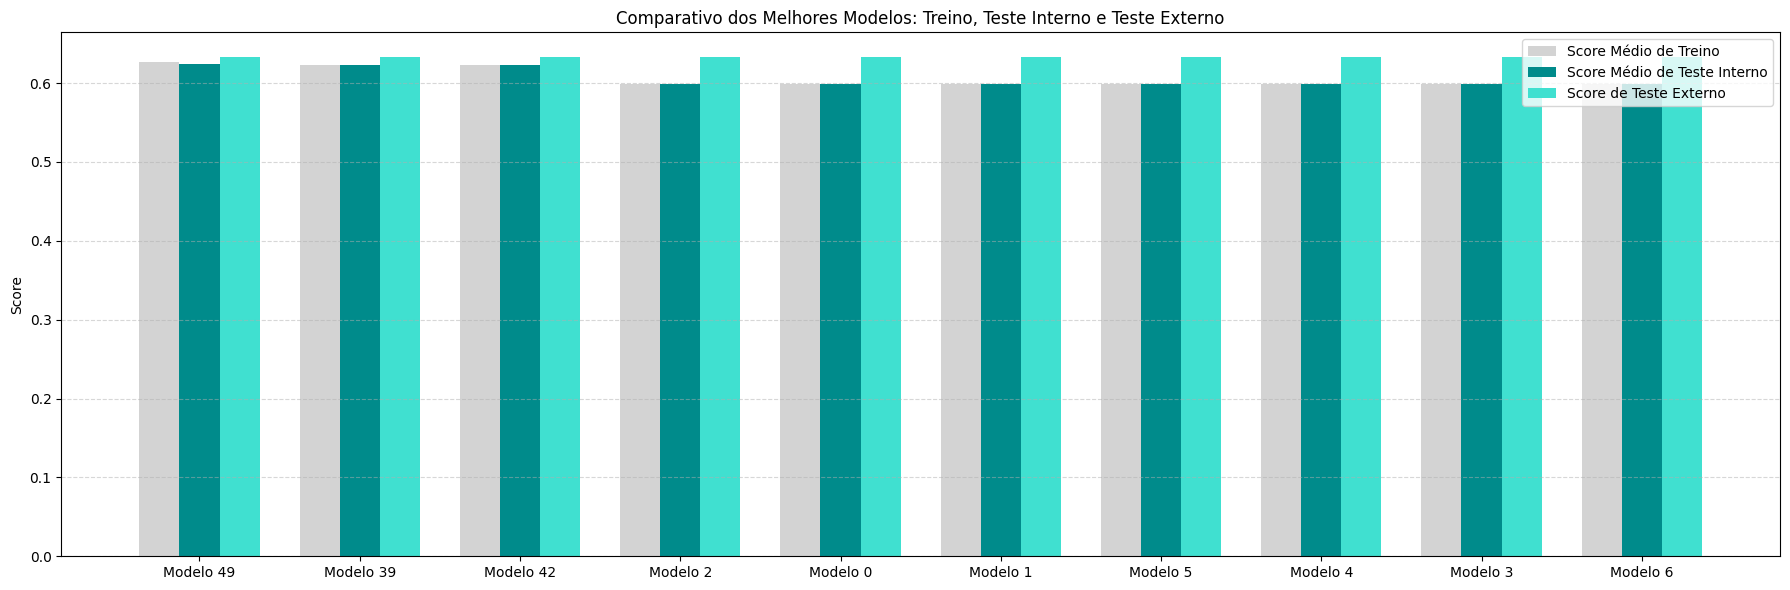

In [106]:
dados_grafico = resultados_filt_ord.head(10)     # Escolha quantos modelos quer exibir
x_pos = np.arange(len(dados_grafico))            # Posições dos rótulos do eixo X
largura_barra = 0.25                             # Largura das barras

plt.figure(figsize=(18, 6))
plt.bar(x_pos - largura_barra,                   # Série com score médio de treino
        dados_grafico["media_score_treino"],
        width=largura_barra,
        label="Score Médio de Treino",
        color="lightgray")
plt.bar(x_pos,                                   # Série com score médio de teste interno
        dados_grafico["media_score_teste_interno"],
        width=largura_barra,
        label="Score Médio de Teste Interno",
        color="darkcyan")
plt.bar(x_pos + largura_barra,                   # Série com score médio de teste externo
        dados_grafico["score_teste_externo"],
        width=largura_barra,
        label="Score de Teste Externo",
        color="turquoise")

plt.xticks(x_pos,
           dados_grafico["num_modelo"],
           rotation=0,
           ha='center')
plt.ylabel("Score")
plt.title("Comparativo dos Melhores Modelos: Treino, Teste Interno e Teste Externo")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

*Escolha do modelo*

In [107]:
num_modelo_escolhido = "Modelo 49"

*Características do modelo escolhido*

In [108]:
linha = resultados.loc[resultados["num_modelo"] == num_modelo_escolhido].squeeze()
nome_algoritmo = linha["nome_algoritmo"]
hiperparametros = linha["hiperparametros"]
classe = algoritmos[nome_algoritmo][0]
print(f"O modelo final adotado foi construído com o algoritmo {nome_algoritmo}, com hiperparâmetros: { {k: round(v, 4) if isinstance(v, float) else v for k, v in hiperparametros.items()} }")

O modelo final adotado foi construído com o algoritmo ÁRVORE DE DECISÃO, com hiperparâmetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': np.float64(0.0028), 'min_samples_leaf': 715, 'min_samples_split': 1744}


*Retreino do modelo no conjunto de treino completo*

In [109]:
modelo_final = classe.set_params(**hiperparametros)
modelo_final.fit(X_treino_tratada, y_treino)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10,
                       min_impurity_decrease=np.float64(0.0028309999967802315),
                       min_samples_leaf=715, min_samples_split=1744,
                       random_state=123)

*Gráfico da árvore*

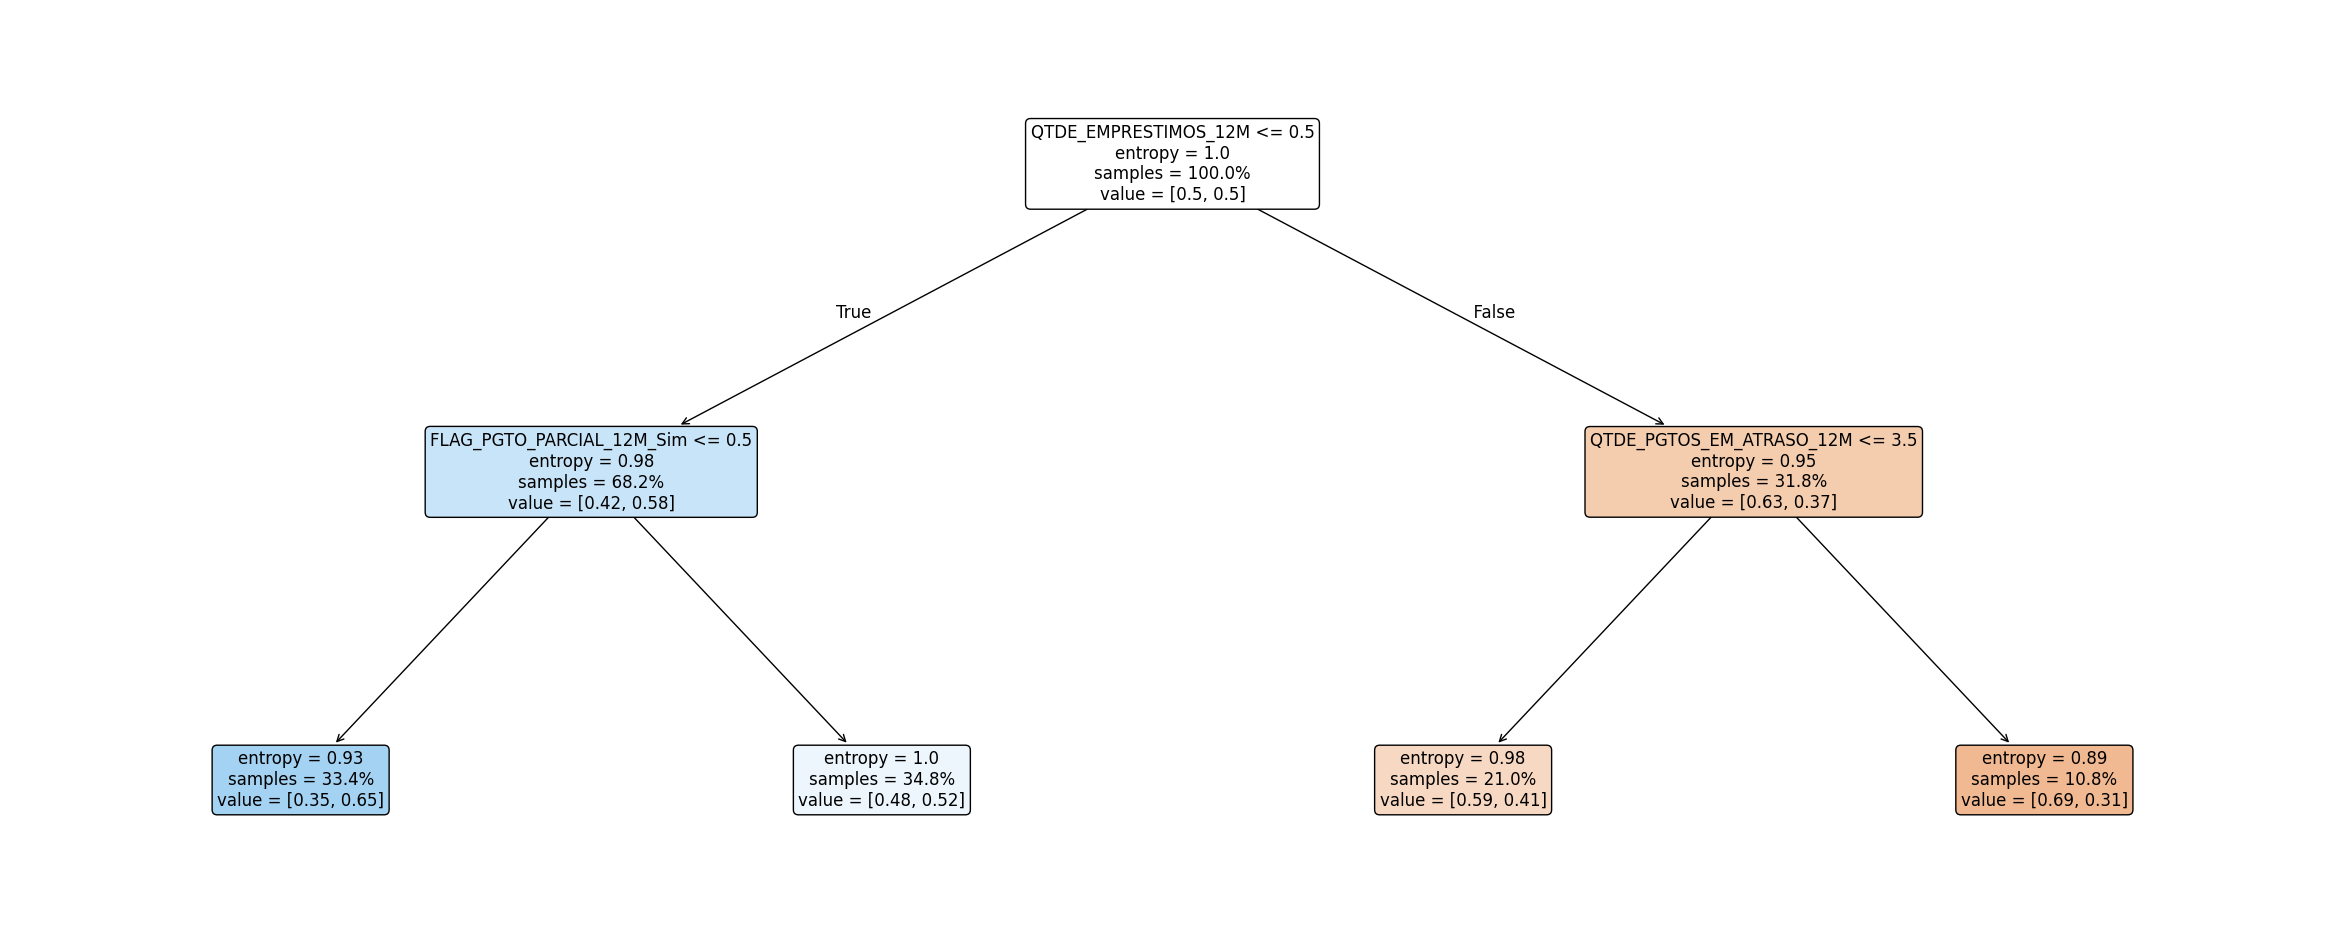

In [110]:
plt.figure(figsize=(30, 12))                        # Ajuste o tamanho da figura para obter uma melhor visualização, a depender do tamanho da árvore
plot_tree(modelo_final,
          feature_names=X_treino_tratada.columns,   # Nomes das variáveis
          filled=True,                              # Cores de preenchimento dos nós
          fontsize=12,                              # Tamanho da fonte dos nós
          proportion=True,                          # Exibição de frequências relativas
          rounded=True,                             # Arredondamento de valores nos nós
          precision=2)                              # Precisão do arredondamento
plt.show()

### **Questão 6**: Calibração

*Aplicação do modelo final no conjunto de teste externo*

In [111]:
p_hat_teste = modelo_final.predict_proba(X_teste_tratada)[:, 1]

*Verificação gráfica de calibração das probabilidades*

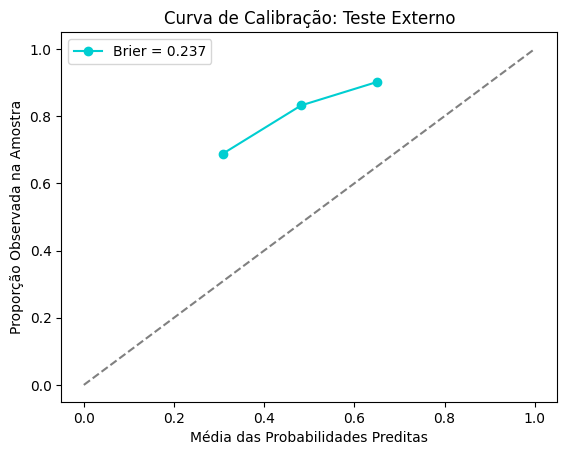

In [112]:
# Cálculos
prop_obs, p_hat_media = calibration_curve(y_teste, p_hat_teste)
brier = brier_score_loss(y_teste, p_hat_teste)

# Gráfico da curva de calibração
plt.plot([0,1],[0,1],'--', color='gray')
plt.plot(p_hat_media, prop_obs, 'o-', color='darkturquoise', label=f"Brier = {brier:.3f}")
plt.xlabel("Média das Probabilidades Preditas")
plt.ylabel("Proporção Observada na Amostra")
plt.title("Curva de Calibração: Teste Externo")
plt.legend()
plt.show()

***(Se necessário)*** *Atualização de probabilidades preditas no teste, por meio de recalibração das probabilidades no conjunto de treino*

In [113]:
# Recalibração do modelo no treino - escolha o método: 'isotonic' (n > 1000) ou 'sigmoid'
modelo_final_calibrado = CalibratedClassifierCV(modelo_final, method='isotonic', cv=5)
modelo_final_calibrado.fit(X_treino_tratada, y_treino)

# Armazenamento de probabilidades não calibradas e cálculo das probabilidades calibradas
p_hat_teste_nao_calibradas = p_hat_teste
p_hat_teste = modelo_final_calibrado.predict_proba(X_teste_tratada)[:,1]

***(Se necessário)*** *Verificação gráfica de calibração das probabilidades - atualização pós calibração*

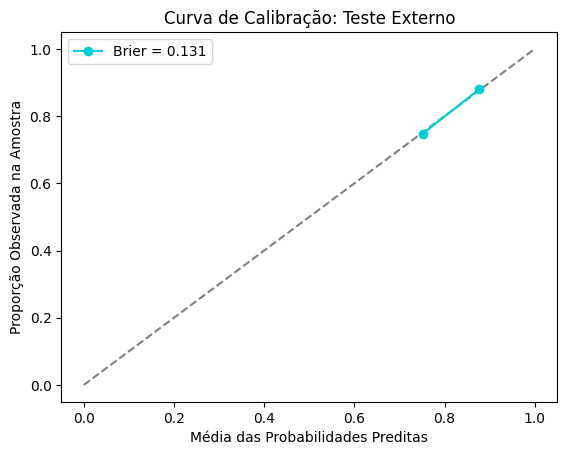

In [114]:
# Cálculos
prop_obs, p_hat_media = calibration_curve(y_teste, p_hat_teste)
brier = brier_score_loss(y_teste, p_hat_teste)

# Gráfico da curva de calibração
plt.plot([0,1],[0,1],'--', color='gray')
plt.plot(p_hat_media, prop_obs, 'o-', color='darkturquoise', label=f"Brier = {brier:.3f}")
plt.xlabel("Média das Probabilidades Preditas")
plt.ylabel("Proporção Observada na Amostra")
plt.title("Curva de Calibração: Teste Externo")
plt.legend()
plt.show()

***(Se necessário)*** *Comparação das probabilidades preditas - antes e depois da calibração*

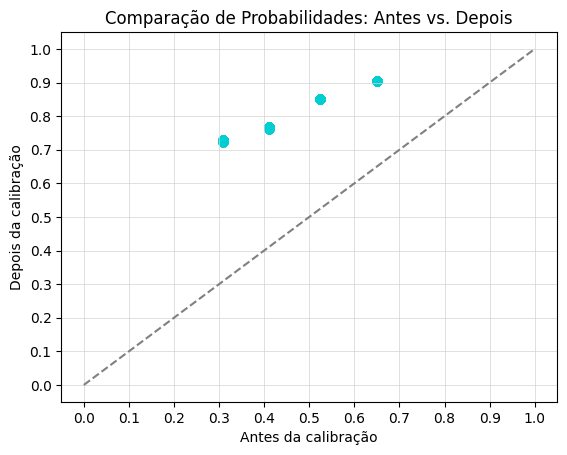

In [115]:
plt.plot([0,1],[0,1],'--', color='gray')
plt.scatter(p_hat_teste_nao_calibradas,
            p_hat_teste,
            color="darkturquoise",
            alpha=0.4)
plt.title("Comparação de Probabilidades: Antes vs. Depois")
plt.xlabel("Antes da calibração")
plt.ylabel("Depois da calibração")
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.5)
plt.show()

*Definição de ponto de corte (padrão: % de 1's no conjunto de treino)* - Mesmo ponto de corte utilizado no Item 4

In [116]:
ponto_corte = y_treino.mean()
ponto_corte

np.float64(0.837600985896207)

*Atribuição da categoria de resposta predita pelo modelo, associado ao ponto de corte*

In [117]:
y_hat_teste = (p_hat_teste > ponto_corte).astype(int)

*Desempenho: acurácia, sensibilidade, especificidade, PPV e NPV*

In [118]:
acuracia       = accuracy_score(y_teste, y_hat_teste)
tn, fp, fn, tp = confusion_matrix(y_teste, y_hat_teste).ravel()
sensibilidade  = tp / (tp + fn)
especificidade = tn / (tn + fp)
acuracia_balanceada = (sensibilidade + especificidade) / 2
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print(f'Acurácia: {acuracia:.3f}')
print(f'Acurácia balanceada: {acuracia_balanceada:.3f}')
print(f'Sensibilidade: {sensibilidade:.3f}')
print(f'Especificidade: {especificidade:.3f}')
print(f'PPV: {ppv:.3f}')
print(f'NPV: {npv:.3f}')

Acurácia: 0.679
Acurácia balanceada: 0.607
Sensibilidade: 0.714
Especificidade: 0.499
PPV: 0.880
NPV: 0.253


*Desempenho: AUC e KS*

In [119]:
# AUC
auc = roc_auc_score(y_teste, p_hat_teste)
print(f'AUC: {auc:.3f}')

AUC: 0.634


In [120]:
# KS
fpr, tpr, _ = roc_curve(y_teste, p_hat_teste)
ks = np.max(tpr - fpr)
print(f'KS: {ks:.3f}')

KS: 0.213


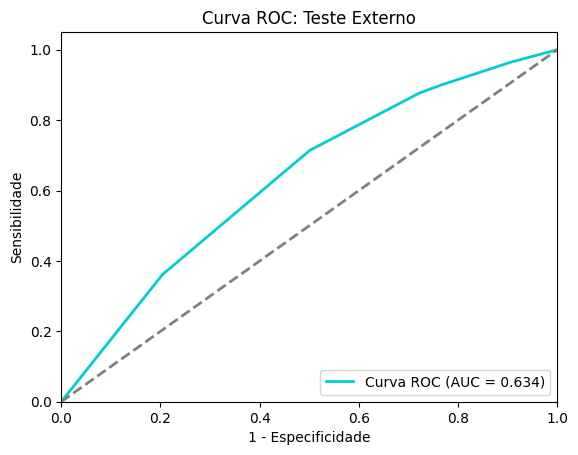

In [121]:
# Exibição da curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkturquoise', lw=2, label='Curva ROC (AUC = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Especificidade')
plt.ylabel('Sensibilidade')
plt.title('Curva ROC: Teste Externo')
plt.legend(loc="lower right")
plt.show()

### **Questão 7:** Modelos de Floresta e Impulsionamento

*Divisão inicial*

In [122]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=123)

In [123]:
y_treino.value_counts()

,count
RESPOSTA_MAU_BOM,
1,12234
0,2372


**Etapa 3: Pré-processamento de variáveis explicativas**

*Definição das funções de pré-processamento: Padronização das variáveis quantitativas + Codificação one-hot para variáveis qualitativas*

In [124]:
preprocessador = ColumnTransformer(transformers=[
    ("quanti", StandardScaler(), lista_X_quanti),
    ("quali", OneHotEncoder(sparse_output=False, drop="first", handle_unknown='ignore'), lista_X_quali)
],
    remainder="passthrough"
)

*Criação do pré-processamento no conjunto de treino* <br>

In [125]:
X_treino_tratada = preprocessador.fit_transform(X_treino)  # O pré-processamento não deve envolver o conjunto de teste externo, que deve ficar reservado apenas para aplicações de resultados já obtidos, e nunca construções
if lista_X_quali:
    nomes_quali = list(preprocessador.named_transformers_['quali'].get_feature_names_out(lista_X_quali))
else:
    nomes_quali = []
nomes_variaveis = list(lista_X_quanti) + nomes_quali

In [126]:
X_treino_tratada = pd.DataFrame(X_treino_tratada, columns=nomes_variaveis)
X_treino_tratada.head()

,IDADE,RENDA_MEDIA_MENSAL,TOTAL_INVESTIMENTOS,QTDE_CONSULTAS_CREDITO_12M,QTDE_CARTOES,QTDE_EMPRESTIMOS_12M,QTDE_CHEQUE_ESPECIAL_12M,QTDE_PGTOS_EM_ATRASO_12M,TOTAL_DIAS_ATRASO_12M,VALOR_PGTOS_12M,PERC_MEDIO_LIMITE_TOMADO_12M,FLAG_PGTO_PARCIAL_12M_Sim
0,-0.386,-1.098,-0.397,0.037,-1.181,-0.568,-0.553,-1.172,-0.692,-1.061,-0.812,0.000
1,0.193,-0.672,1.880,2.787,-0.598,-0.568,-0.553,-0.627,-0.459,-0.144,1.880,0.000
2,-0.096,0.411,-0.337,1.412,-0.015,1.998,0.542,-0.081,0.983,-0.386,-0.543,1.000
3,0.387,0.394,-0.485,-0.651,-0.598,-0.568,0.542,-0.081,-0.413,0.453,-1.120,1.000
4,-0.676,-0.512,-0.561,0.724,1.734,1.998,0.542,0.464,2.379,-0.220,-0.428,1.000


*Aplicação do pré-processamento no conjunto de teste externo*

In [127]:
X_teste_tratada = preprocessador.transform(X_teste)  # Note que o mesmo objeto de pré-processamento deve ser utilizado, agora com 'transform' em vez de 'fit_transform'
X_teste_tratada = pd.DataFrame(X_teste_tratada, columns=nomes_variaveis)
X_teste_tratada.head()

,IDADE,RENDA_MEDIA_MENSAL,TOTAL_INVESTIMENTOS,QTDE_CONSULTAS_CREDITO_12M,QTDE_CARTOES,QTDE_EMPRESTIMOS_12M,QTDE_CHEQUE_ESPECIAL_12M,QTDE_PGTOS_EM_ATRASO_12M,TOTAL_DIAS_ATRASO_12M,VALOR_PGTOS_12M,PERC_MEDIO_LIMITE_TOMADO_12M,FLAG_PGTO_PARCIAL_12M_Sim
0,-1.062,0.127,3.613,-0.651,-0.598,-0.568,-0.553,0.464,-0.506,-0.878,0.303,1.000
1,-1.545,-1.186,-0.555,-0.651,-0.598,-0.568,1.637,-0.627,-0.320,0.301,-0.774,1.000
2,-1.159,1.654,-0.245,2.099,1.151,0.715,1.637,-0.627,1.169,-1.001,-1.159,1.000
3,1.546,1.689,1.105,2.099,1.151,0.715,1.637,2.101,1.727,-1.003,1.149,1.000
4,0.580,-1.062,-0.305,-0.651,-0.598,-0.568,-1.649,-0.627,-0.552,-0.555,-0.466,1.000


**Etapa 4: Definição do algoritmo e intervalos de busca de hiperparâmetros**

In [128]:
algoritmos = {

    'FLORESTA ALEATÓRIA': (RandomForestClassifier(random_state=123, n_jobs = -1), {
        'n_estimators': randint(10, 301),             # Qtde. de árvores na floresta
        'min_impurity_decrease': uniform(0, 0.05),    # Valor mínimo de redução de impureza
        'min_samples_split': randint(100, 201),       # Qtde. mínima de observações no nó "pai" (ATENÇÃO: depende do tamanho da base)
        'min_samples_leaf': randint(50, 101),         # Qtde. mínima de observações no nó "filho" (ATENÇÃO: depende do tamanho da base)
        'max_samples': uniform(0.6, 0.4),             # Percentual de observações consideradas em cada árvore
        'max_features': ['sqrt', 'log2', None],       # Qtde. de variáveis consideradas em cada árvore
        'max_depth': randint(2, 11)                   # Profundidade máxima das árvores
    }),

    'ADABOOST': (AdaBoostClassifier(random_state=123), {
        'n_estimators': randint(10, 301),             # Qtde. de árvores no boosting
        'learning_rate': loguniform(1e-4, 1e-1)       # Taxa de aprendizado
    }),

    'GRADIENT BOOSTING': (GradientBoostingClassifier(random_state=123), {
        'n_estimators': randint(10, 301),             # Qtde. de árvores no boosting
        'min_impurity_decrease': uniform(0, 0.05),    # Valor mínimo de redução de impureza
        'learning_rate': loguniform(1e-4, 1e-1),      # Taxa de aprendizado
        'min_samples_split': randint(100, 201),       # Qtde. mínima de observações no nó "pai" (ATENÇÃO: depende do tamanho da base)
        'min_samples_leaf': randint(50, 101),         # Qtde. mínima de observações no nó "filho" (ATENÇÃO: depende do tamanho da base)
        'subsample': uniform(0.6, 0.4),               # Percentual de observações consideradas em cada árvore
        'max_features': ['sqrt', 'log2', None],       # Qtde. de variáveis consideradas em cada árvore
        'max_depth': randint(2, 11)                   # Profundidade máxima das árvores
    }),

    'GRADIENT BOOSTING COM HISTOGRAMAS': (HistGradientBoostingClassifier(random_state=123), {
        'max_iter': randint(10, 301),                 # Qtde. de árvores no boosting
        'learning_rate': loguniform(1e-4, 1e-1),      # Taxa de aprendizado
        'min_samples_leaf': randint(50, 101),         # Qtde. mínima de observações no nó "filho" (ATENÇÃO: depende do tamanho da base)
        'max_leaf_nodes': randint(10, 31),            # Qtde. máxima de nós finais (ATENÇÃO: depende do tamanho da base)
        'max_bins': randint(10, 255),                 # Qtde. máxima de bins para discretização
        'l2_regularization': loguniform(1e-5, 1e2),   # Contribuição da penalização Ridge (L2)
        'max_depth': randint(2, 11)                   # Profundidade máxima das árvores
    }),

    'XGBOOST': (XGBClassifier(random_state=123, n_jobs=-1), {
        'n_estimators': randint(10, 301),             # Qtde. de árvores no boosting
        'learning_rate': loguniform(1e-4, 1e-1),      # Taxa de aprendizado
        'colsample_bytree': uniform(0.5, 0.5),        # Percentual de variáveis consideradas em cada árvore
        'subsample': uniform(0.6, 0.4),               # Percentual de observações consideradas em cada árvore
        'gamma': uniform(0, 5),                       # Redução mínima na função de perda para realizar uma quebra
        'reg_alpha': loguniform(1e-5, 1e2),           # Contribuição da penalização LASSO (L1)
        'reg_lambda': loguniform(1e-5, 1e2),          # Contribuição da penalização Ridge (L2)
        'max_depth': randint(2, 11)                   # Profundidade máxima das árvores
    }),

    'LIGHTGBM': (LGBMClassifier(random_state=123, n_jobs=-1, verbosity=-1), {
        'n_estimators': randint(10, 301),             # Qtde. de árvores no boosting
        'learning_rate': loguniform(1e-4, 1e-1),      # Taxa de aprendizado
        'min_child_samples': randint(50, 101),        # Qtde. mínima de observações no nó "filho" (ATENÇÃO: depende do tamanho da base)
        'num_leaves': randint(10, 31),                # Qtde. máxima de nós finais (ATENÇÃO: depende do tamanho da base)
        'subsample': uniform(0.6, 0.4),               # Percentual de observações consideradas em cada árvore
        'reg_alpha': loguniform(1e-5, 1e2),           # Contribuição da penalização LASSO (L1)
        'reg_lambda': loguniform(1e-5, 1e2),          # Contribuição da penalização Ridge (L2)
        'max_depth': randint(2, 11)                   # Profundidade máxima das árvores
    })

}

**Etapa 5: Construção de modelos usando validação cruzada, busca aleatória e teste externo**

*Estratégia de validação cruzada estratificada (stratified k-fold) e quantidade máxima de iterações de busca*

In [129]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
qtd_iteracoes = 50

*Construção dos modelos*

In [130]:
resultados = []                                                              # Lista para armazenar resultados
contador_modelos = 0                                                         # Contador de modelos testados
pesos_treino = compute_sample_weight(class_weight='balanced', y=y_treino)    # Pesos das observações no treino (pois alguns algoritmos não aceitam o argumento 'class_weight')

for nome_algoritmo, (classe_algoritmo, hiperparametros) in algoritmos.items():

    # Início da contagem de tempo e de modelos
    inicio = time.time()

    # Busca aleatória de hiperparâmetros com validação cruzada (randomized search)
    busca = RandomizedSearchCV(
        estimator=classe_algoritmo,
        param_distributions=hiperparametros,
        n_iter=1 if not hiperparametros else qtd_iteracoes,
        scoring='roc_auc',
        cv=kf,
        return_train_score=True,
        random_state=123,
        n_jobs=-1
    )

    # Ajuste dos modelos
    busca.fit(X_treino_tratada, y_treino, sample_weight=pesos_treino)

    # Armazenar os resultados da busca
    resultados_aux = pd.DataFrame({
        "num_modelo": [f"Modelo {contador_modelos + i}" for i in range(len(busca.cv_results_["params"]))],
        "nome_algoritmo": nome_algoritmo,
        "classe_algoritmo": type(classe_algoritmo).__name__,
        "hiperparametros": busca.cv_results_["params"],
        "media_score_treino": busca.cv_results_["mean_train_score"],
        "media_score_teste_interno": busca.cv_results_["mean_test_score"],
        "dp_score_treino": busca.cv_results_["std_train_score"],
        "dp_score_teste_interno": busca.cv_results_["std_test_score"]
    })

    metrica = "roc_auc"
    scorer = get_scorer(metrica)

    # Calcular score no teste externo, para cada modelo
    score_teste = []
    for params in resultados_aux["hiperparametros"]:
        estimador = busca.best_estimator_
        p_hat_teste = estimador.predict_proba(X_teste_tratada)[:, 1]
        score = scorer(estimador, X_teste_tratada, y_teste)
        score_teste.append(score)

    # Adicionar coluna de score em teste externo e colunas de variações absolutas de score em relação ao treino
    resultados_aux["score_teste_externo"] = score_teste
    resultados_aux["var_abs_media_score_teste_interno"] = abs(resultados_aux["media_score_teste_interno"] - resultados_aux["media_score_treino"])
    resultados_aux["var_abs_score_teste_externo"] = abs(resultados_aux["score_teste_externo"] - resultados_aux["media_score_treino"])

    resultados.append(resultados_aux)
    contador_modelos += len(resultados_aux)

    # Fim da contagem de tempo e mensagem de finalização
    fim = time.time()
    print(f"({math.ceil(contador_modelos/qtd_iteracoes)} de {len(algoritmos)}) Processo concluído para o algoritmo {nome_algoritmo} em {fim - inicio:.1f} segundos!")

# Criação de data frame com os resultados
resultados = pd.concat(resultados, ignore_index=True)

(1 de 6) Processo concluído para o algoritmo FLORESTA ALEATÓRIA em 216.2 segundos!


KeyboardInterrupt: 

**Etapa 6: Comparação de modelos**

*Ordenação dos melhores modelos*

In [ ]:
# Escolha por qual coluna ordenar
ordenar_por = "media_score_teste_interno"
# ordenar_por = "score_teste_externo"

# Escolha quais o percentuais máximos de variação de score (da média do treino para a média do teste interno; e da média do treino para o teste externo)
max_var_perc_score_teste_interno = 0.1  # ex.: 0.1 representa 10%
max_var_perc_score_teste_externo = 0.1

# Ordenação e filtragem
resultados_filt_ord = resultados[(resultados['var_abs_media_score_teste_interno'] < max_var_perc_score_teste_interno) & (resultados['var_abs_score_teste_externo'] < max_var_perc_score_teste_externo)]
resultados_filt_ord = resultados_filt_ord.sort_values(ordenar_por, ascending=False)

*Exibição dos melhores modelos, em formato de tabela e gráfico*

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)   # Quantidade de casas decimais
resultados_filt_ord[['num_modelo',
                     'nome_algoritmo',
                     'hiperparametros',
                     'media_score_treino',
                     'dp_score_treino',
                     'media_score_teste_interno',
                     'dp_score_teste_interno',
                     'var_abs_media_score_teste_interno',
                     'score_teste_externo',
                     'var_abs_score_teste_externo']].head(10)   # Escolha quantos modelos quer exibir

In [ ]:
dados_grafico = resultados_filt_ord.head(10)     # Escolha quantos modelos quer exibir
x_pos = np.arange(len(dados_grafico))            # Posições dos rótulos do eixo X
largura_barra = 0.25                             # Largura das barras

plt.figure(figsize=(18, 6))
plt.bar(x_pos - largura_barra,                   # Série com score médio de treino
        dados_grafico["media_score_treino"],
        width=largura_barra,
        label="Score Médio de Treino",
        color="lightgray")
plt.bar(x_pos,                                   # Série com score médio de teste interno
        dados_grafico["media_score_teste_interno"],
        width=largura_barra,
        label="Score Médio de Teste Interno",
        color="darkcyan")
plt.bar(x_pos + largura_barra,                   # Série com score médio de teste externo
        dados_grafico["score_teste_externo"],
        width=largura_barra,
        label="Score de Teste Externo",
        color="turquoise")

plt.xticks(x_pos,
           dados_grafico["num_modelo"],
           rotation=0,
           ha='center')
plt.ylabel("Score")
plt.title("Comparativo dos Melhores Modelos: Treino, Teste Interno e Teste Externo")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Etapa 7: Escolha do modelo**

*Escolha do modelo*

In [ ]:
num_modelo_escolhido = "Modelo 586"

*Características do modelo escolhido*

In [ ]:
linha = resultados.loc[resultados["num_modelo"] == num_modelo_escolhido].squeeze()
nome_algoritmo = linha["nome_algoritmo"]
hiperparametros = linha["hiperparametros"]
classe = algoritmos[nome_algoritmo][0]
print(f"O modelo final adotado foi construído com o algoritmo {nome_algoritmo}, com hiperparâmetros: { {k: round(v, 4) if isinstance(v, float) else v for k, v in hiperparametros.items()} }")

*Retreino do modelo no conjunto de treino completo*

In [ ]:
modelo_final = classe.set_params(**hiperparametros)
modelo_final.fit(X_treino_tratada, y_treino, sample_weight=pesos_treino)